# Neural Style Transfer 

In [1]:
!pip install tensorflow_probability==0.18.0

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential

from scipy.optimize import fmin_l_bfgs_b
import scipy as sp
import tensorflow_probability as tfp

import numpy as np
import cv2

import matplotlib.pyplot as plt

from skimage import io

import imageio
from IPython.display import Image

## Images

In [85]:
IMG_SIZE = [450,450]

Style_img = io.imread('https://creazilla-store.fra1.digitaloceanspaces.com/vectors/6384/winter-landscape-stained-glass-style-illustration-vector-md.png')
Style_img = tf.cast(cv2.resize(Style_img[:,:,:3], IMG_SIZE), dtype=tf.float32)

Content_img = io.imread('https://img.freepik.com/premium-photo/pomeranian-dog-white-background_63176-471.jpg?w=900')
Content_img = tf.cast(cv2.resize(Content_img, IMG_SIZE), dtype=tf.float32)


Combine_img =  Content_img #* tf.random.uniform(IMG_SIZE + [3], minval=0, maxval=1, dtype=tf.float32)

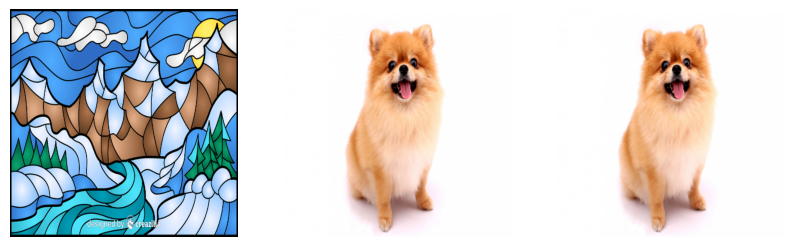

In [86]:
plt.rcParams["figure.figsize"] = (10,25)
fig, axs = plt.subplots(1,3)

axs[0].imshow(tf.cast(Style_img , dtype=tf.uint8))
axs[0].axis('off')
axs[1].imshow(tf.cast(Content_img , dtype=tf.uint8))
axs[1].axis('off')
axs[2].imshow(tf.cast(Combine_img , dtype=tf.uint8))
axs[2].axis('off');

## Model

$$ L_{content}(p,x,l) = \frac{1}{2}\sum_{ij} (F_{ij}^l (x) - P_{ij}^l )^2$$
$$G_{ij}^l = \sum_k F_{ik}^l F{jk}^l$$

In [96]:
class NST():
    def __init__(self, epoch, alpha, beta, lr) -> None:
        self.EPOCH = epoch
        self.ALPHA = alpha  #Content img weight 
        self.BETA = beta  #Style img weight
        self.Learning_Rate = lr
        
        self.vgg19 = VGG19(include_top=False, weights='imagenet')
        
        for layer in self.vgg19.layers:
            layer.Trainable = False
        
        tf.keras.backend.clear_session()

        self.Style_layers = ['block1_conv1','block2_conv1', 'block3_conv1','block4_conv1','block5_conv1']
        self.Content_layer = ['block5_conv2']


        Content_outputs =  [self.vgg19.get_layer(layer).output for layer in self.Content_layer]
        Style_outputs =  [self.vgg19.get_layer(layer).output for layer in self.Style_layers]

        self.model = Model(inputs = self.vgg19.inputs, outputs = Style_outputs + Content_outputs)


    def func(self,x):
        return [vv.numpy().astype(np.float64)  for vv in self.compute_loss_and_gradients(tf.constant(x, dtype=tf.float32)) ]

    def Gram_matrix(self, tensor):
        shape = tensor.shape
        filters = shape[2]
        feature_map_size = shape[0]*shape[1]
        
        matrix = tf.reshape(tensor, shape = (filters,feature_map_size ))
        gmatrix = tf.matmul(matrix, matrix , transpose_b=True)
        
        return [gmatrix, filters, feature_map_size]
        
    def Loss_function(self, Combine_img):
        """
        N_l = Number of feature maps
        M_l = Size of the flattened tensor for Gram Matrix
        
        Args:
            Content_img (_type_): _description_
            Style_img (_type_): _description_
            Combine_img (_type_): _description_
        """
        Combine_img = tf.reshape(Combine_img,[1] + IMG_SIZE + [3])

        input_tensor = tf.concat([self.Content_img, self.Style_img, Combine_img], axis=0)
        input_tensor = tf.cast(input_tensor, tf.float64)

        features = self.model(input_tensor) 

        Content_out = features[-1][0]
        Content_combine_out = features[-1][2]

        Style_features = [feature[1] for feature in features[:5]]
        Style_combination_features = [feature[2] for feature in features[:5]]

        Style_GM = [self.Gram_matrix(layer) for layer in Style_features]
        Style_combination_GM = [self.Gram_matrix(layer) for layer in Style_combination_features]        

        Content_loss = self.ALPHA * tf.keras.backend.sum(tf.square(Content_out - Content_combine_out))
        Style_loss = 0

        for i in range( len(self.Style_layers) ):
            N_l = Style_GM[i][1]
            M_l = Style_GM[i][2]

            E = tf.keras.backend.sum(tf.square(Style_combination_GM[i][0] - Style_GM[i][0])) * 1/(4 * N_l**2 * M_l**2) 
            Style_loss += self.BETA * E
        
        Loss = Content_loss + Style_loss
        return Loss

    @tf.function
    def compute_loss_and_gradients(self, Combine_img):
        """Calculation of the loss and gradient with respect to the input 

        Args:
            Content_img (tensor)
            Style_img (tensor)
            Combine_img (tensor)

        Returns:
            _type_: [gradients, loss]
        """
        with tf.GradientTape() as tape:
            tape.watch(Combine_img)
            loss = self.Loss_function(Combine_img)
        tf.clip_by_value(Combine_img, 0, 255)
        grads = tape.gradient(loss, Combine_img)

        return tf.cast(loss, dtype=tf.float64), tf.cast(grads, dtype=tf.float64)

    def get_loss(self, x):
        loss , self.grads = self.compute_loss_and_gradients( tf.cast(x, dtype=tf.float32) )
        return loss
    
    def get_grads(self,x):
        return np.copy(self.grads)


    def unprocess_image(self, img):
        mean = [103.939, 116.779, 123.68]
        img = img.numpy()
        
        #img = np.squeeze(img, 0)

        img[:, :, 0] += mean[0]
        img[:, :, 1] += mean[1]
        img[:, :, 2] += mean[2]
        
        #BGR -> RGB
        img = img[:, :, ::-1]

        img = np.clip(img, 0, 255).astype('uint8')

        return img

    def run(self, Content_img, Style_img, Combine_img):
        imgs = []

        self.Content_img = tf.cast( preprocess_input(tf.expand_dims(Content_img, axis=0)), dtype=tf.float32 )
        self.Style_img = tf.cast( preprocess_input(tf.expand_dims(Style_img, axis=0)), dtype=tf.float32 )
        
        Combine_img = preprocess_input(tf.expand_dims(Combine_img, axis=0))
        Combine_img = tf.Variable(Combine_img)
  
        for i in range(self.EPOCH + 1):
            Combine_img, loss, info  = fmin_l_bfgs_b(func = self.get_loss,fprime=self.get_grads,x0 = Combine_img, maxfun = 20, maxls = 30)

            Combine_img = tf.cast(tf.reshape(Combine_img, IMG_SIZE +[3]) , dtype = tf.float32)
            Combine_img = tf.clip_by_value(Combine_img, 0, 255)

            if i%10 == 0:
                print("Epoch: {}, Loss: {}".format(i, loss))
                imgs.append([self.unprocess_image(Combine_img), loss])
        
        imageio.mimsave('./images/nst.gif', [img[0] for img in imgs], fps = 2)
        
        return imgs

Epoch: 0, Loss: 433011936.0
Epoch: 10, Loss: 84309648.0
Epoch: 20, Loss: 67422752.0
Epoch: 30, Loss: 59942120.0
Epoch: 40, Loss: 55681752.0
Epoch: 50, Loss: 52771412.0
Epoch: 60, Loss: 50698952.0
Epoch: 70, Loss: 49226256.0
Epoch: 80, Loss: 48149584.0
Epoch: 90, Loss: 47274140.0
Epoch: 100, Loss: 46547876.0


(-0.5, 1349.5, 449.5, -0.5)

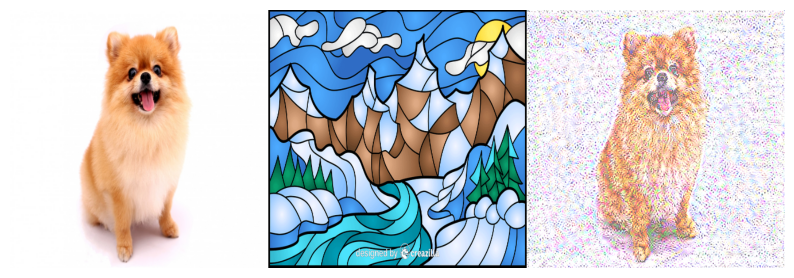

In [100]:
EPOCH = 100
ALPHA = 1  #Content img weight 
BETA = 1e-2   #Style img weight
Learning_Rate = 1

model = NST(EPOCH, ALPHA, BETA, Learning_Rate)
imgs = model.run(Content_img, Style_img, Combine_img)

imgs.sort(key = lambda x: x[1])

plt.imshow(np.concatenate(( np.array(Content_img.numpy(), dtype = 'uint8'),np.array(Style_img.numpy(), dtype = 'uint8') ,imgs[0][0]), axis = 1))
plt.axis('off')


## Results

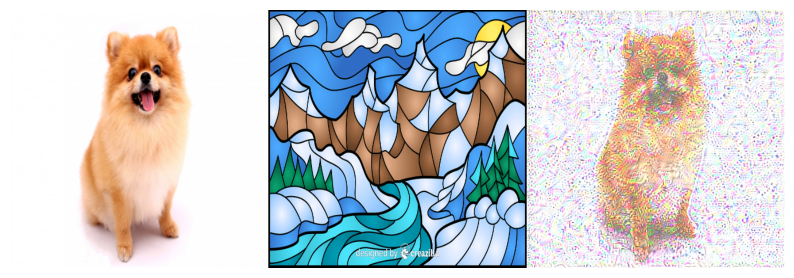

In [89]:
plt.imshow(np.concatenate(( np.array(Content_img.numpy(), dtype = 'uint8'),np.array(Style_img.numpy(), dtype = 'uint8') ,imgs[0][0]), axis = 1))
plt.axis('off');

In [ ]:
from IPython.display import Image
Image(url = './images/nst.gif')